# Evaluate GPT models

## SuperGLUE benchmarks

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score, classification_report, confusion_matrix
from statistics import mean
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk import ngrams
import nltk
from lime.lime_text import LimeTextExplainer

### Task 1: Choice of plausible alternartives: COPA

In [3]:
df_copa = pd.read_csv("SuperGLUE/COPA-COPA.csv", sep=";")
df_copa

,Premise,Choice_1,Choice_2,Label,Label_no_ft,Label_directive,Label_legends
0,The board of directors did not respect the gen...,The supervisory authority has applied a sanction.,The company has increased its dividends.,1,1,1,1
1,The company has introduced policies to promote...,Productivity has dropped.,The company's reputation has improved.,2,2,2,2
2,The regulator has published new guidelines on ...,The companies have adapted the selection proce...,The shareholders sold en masse.,1,1,2,1
3,A listed company ignored the provisions of the...,Sales in the sector have increased.,Public opinion has criticized governance.,2,2,2,2
4,The council has reached 40% of female presence.,The council has been reduced in size.,The company has complied with the directive.,2,2,2,2
5,The non-compliance with the quotas was reporte...,The company suffered reputational damage.,The council received an award.,1,1,1,1
6,A company has implemented female mentoring pro...,More women have reached leadership positions.,Quarterly earnings decreased for no reason.,1,1,1,1
7,The European Parliament has approved the direc...,The companies have laid off half of the techni...,The companies have gradually adapted.,2,2,2,2
8,The shareholders' meeting rejected the appoint...,"The company had to propose a new, more balance...",Employees went on strike for wage reasons.,1,1,1,1
9,The company has complied with the objectives o...,It has drastically reduced investments.,It has improved the image on the market.,2,2,2,2


In [4]:
llms = ["_no_ft", "_directive", "_legends"]

results_copa = {}

print("Choice of plausible alternatives metrics:")

for llm in llms:
    y_true = df_copa["Label"]
    y_pred = df_copa["Label"+llm]
    
    mcc = matthews_corrcoef(y_true, y_pred)
    accuracy = accuracy_score(y_true,y_pred)
    
    results_copa["Model"+llm] = {
        "accuracy": accuracy
    }
    
    print(f"--- {"Model"+llm} ---")
    print(f"Accuracy: {accuracy:.3f}\n")

Choice of plausible alternatives metrics:
--- Model_no_ft ---
Accuracy: 1.000

--- Model_directive ---
Accuracy: 0.900

--- Model_legends ---
Accuracy: 1.000



### Task 2: MultiRC

In [5]:
df_multirc = pd.read_csv("SuperGLUE/MULTIRC-MULTIRC.csv", sep=";")
df_multirc

,Passage,Question,Answer_1,Answer_2,Label_1,Label_2,Label_1_no_ft,Label_2_no_ft,Label_1_directive,Label_2_directive,Label_1_legends,Label_2_legends
0,Directive 2022/2381 requires that at least 40%...,What is the minimum percentage for the underre...,40%,25%,1,0,1,0,1,0,1,0
1,"According to the directive, Member States must...",What happens if a company does not comply?,Sanctions are imposed.,Legal action may be initiated.,1,1,1,1,1,1,1,1
2,The directive applies to companies listed on r...,Which companies does the directive apply to?,Small unlisted companies.,Listed companies.,0,1,0,1,0,1,0,1
3,Member States must ensure that selection proce...,What is a requirement for selection procedures?,They must be transparent.,They must be merit-based.,1,1,1,1,1,1,1,1
4,"If two candidates have equal qualifications, t...",Who is favored in case of equal qualifications?,The candidate of the underrepresented sex.,The less experienced candidate.,1,0,1,0,1,0,1,0
5,The directive requires the rules to be impleme...,What is the deadline for implementation?,2026.,2035.,1,0,1,0,1,0,1,0
6,Member States must periodically report to the ...,What must Member States do?,Send periodic reports.,Provide compliance statistics.,1,1,1,1,1,1,1,1
7,Companies that meet the target may still impro...,What happens to compliant companies?,They can continue strengthening diversity.,They are excluded from the directive.,1,0,1,0,1,0,1,0
8,Failure to comply with the rules may negativel...,What is a consequence of non-compliance?,Reputational damage.,Financial penalties.,1,1,1,1,1,1,1,1
9,The directive promotes gender balance on board...,What is the main purpose of the directive?,Improve governance.,Enhance decision-making quality.,1,1,1,1,1,0,1,1


In [6]:
y_true = [df_multirc["Label_1"], df_multirc['Label_2']]

y_pred_no_ft = [df_multirc["Label_1_no_ft"], df_multirc["Label_2_no_ft"]]
f1_no_ft = f1_score(y_true, y_pred_no_ft, average="macro")

y_pred_directive = [df_multirc["Label_1_directive"], df_multirc["Label_2_directive"]]
f1_directive = f1_score(y_true, y_pred_directive, average="macro")

y_pred_legends = [df_multirc["Label_1_legends"], df_multirc["Label_2_legends"]]
f1_legends = f1_score(y_true, y_pred_legends, average="macro")

In [7]:
llms = ["_no_ft", "_directive", "_legends"]
em_scores = {}

for llm in llms:
    results = []
    for row in range(len(df_multirc)):
        if (df_multirc['Label_1'+llm][row] == df_multirc['Label_1'][row] and df_multirc['Label_2'+llm][row] == df_multirc['Label_2'][row]):
            results.append(1)
        else:
            results.append(0)
    em_scores['Model'+llm] = sum(results) / len(results)

In [8]:
results_multirc = {}
results_multirc["Model_no_ft"] = {
    "f1" : f1_no_ft,
    "em_score" : em_scores["Model_no_ft"]
}
results_multirc["Model_directive"] = {
    "f1" : f1_directive,
    "em_score" : em_scores["Model_directive"]
}
results_multirc["Model_legends"] = {
    "f1" : f1_legends,
    "em_score" : em_scores["Model_legends"]
}

print("MultiRC metrics:")

for llm in results_multirc.keys():
    print(f"--- {llm} ---")
    print(f"f1: {results_multirc[llm]["f1"]:.3f}")
    print(f"em_score: {results_multirc[llm]["em_score"]:.3f}")
    print()

MultiRC metrics:
--- Model_no_ft ---
f1: 1.000
em_score: 1.000

--- Model_directive ---
f1: 0.967
em_score: 0.900

--- Model_legends ---
f1: 1.000
em_score: 1.000



### Task 3: RTE (Legal Entailment)

In [9]:
df_le = pd.read_csv("SuperGLUE/LE-Legal Entailment.csv", sep=";")
df_le

,Premise,Hypothesis,Label,Label_no_ft,Label_directive,Label_legends
0,Directive 2022/2381 states that at least 40% o...,Companies must ensure that 40% of the board is...,entailment,not_entailment,not_entailment,not_entailment
1,The directive requires transparency in selecti...,Companies may appoint directors without public...,not_entailment,not_entailment,not_entailment,not_entailment
2,Member States must introduce sanctions for non...,A company that ignores the directive faces no ...,not_entailment,not_entailment,not_entailment,not_entailment
3,The directive only applies to companies listed...,Family-owned unlisted businesses must also com...,not_entailment,not_entailment,not_entailment,not_entailment
4,"If two candidates have equal qualifications, t...","In case of equal merit, a woman is favored if ...",entailment,entailment,entailment,entailment
5,The directive must be implemented by 2026.,Measures must be operational by 2026.,entailment,entailment,entailment,entailment
6,Member States must send periodic reports to th...,Governments must communicate progress to Bruss...,entailment,entailment,entailment,entailment
7,The directive does not change individual emplo...,The provisions affect individual employee cont...,not_entailment,not_entailment,not_entailment,not_entailment
8,The directive aims to improve corporate govern...,The goal is to strengthen transparency and boa...,entailment,entailment,entailment,entailment
9,The directive concerns gender balance on boards.,The regulation is focused on data protection.,not_entailment,not_entailment,not_entailment,not_entailment


In [10]:
llms = ["_no_ft", "_directive", "_legends"]

results_le = {}

print("RTE (legal entailment) metrics:")

for llm in llms:
    y_true = df_le["Label"]
    y_pred = df_le["Label"+llm]
    
    mcc = matthews_corrcoef(y_true, y_pred)
    accuracy = accuracy_score(y_true,y_pred)
    
    results_le["Model"+llm] = {
        "accuracy": accuracy
    }
    
    print(f"--- {"Model"+llm} ---")
    print(f"Accuracy: {accuracy:.3f}\n")

RTE (legal entailment) metrics:
--- Model_no_ft ---
Accuracy: 0.900

--- Model_directive ---
Accuracy: 0.900

--- Model_legends ---
Accuracy: 0.900



### Task 4: Word in Context

In [11]:
df_wic = pd.read_csv("SuperGLUE/WIC-WIC.csv", sep=";")
df_wic

,Sentence_1,Sentence_2,Word,Label,Label_no_ft,Label_directive,Label_legends
0,The board promoted gender balance in appointme...,The gender of the candidate was clearly indica...,gender,1,1,1,1
1,The manager showed great respect for the emplo...,The directive requires shareholders to show re...,respect,1,1,0,0
2,Gender quotas were reached by the company in l...,The gender of the newborn was celebrated at home.,gender,0,0,1,0
3,The employee suffered discrimination due to la...,The company suffered sanctions for not meeting...,suffered,0,0,0,1
4,The board of directors adopted new measures to...,The school board discussed unrelated matters a...,board,0,0,0,0
5,The role of the chairperson was crucial in imp...,His role in drafting the compliance report was...,role,1,1,1,1
6,The selection of candidates ensured compliance...,Natural selection explains adaptation in biology.,selection,0,0,0,0
7,The annual financial report included a section...,The report on gender representation was submit...,report,1,1,1,1
8,The presence of women on boards increased afte...,The constant presence of auditors ensured tran...,presence,1,1,1,1
9,Gender balance was respected by appointing mor...,Financial balance was maintained despite restr...,balance,0,0,0,0


In [12]:
llms = ["_no_ft", "_directive", "_legends"]

results_wic = {}

print("WIC (word in context) metrics:")

for llm in llms:
    y_true = df_wic["Label"]
    y_pred = df_wic["Label"+llm]
    
    mcc = matthews_corrcoef(y_true, y_pred)
    accuracy = accuracy_score(y_true,y_pred)
    
    results_wic["Model"+llm] = {
        "accuracy": accuracy
    }
    
    print(f"--- {"Model"+llm} ---")
    print(f"Accuracy: {accuracy:.3f}\n")

WIC (word in context) metrics:
--- Model_no_ft ---
Accuracy: 1.000

--- Model_directive ---
Accuracy: 0.800

--- Model_legends ---
Accuracy: 0.800



### Macro-average

In [13]:
llms = ["_no_ft", "_directive", "_legends"]
    
macro_average = {}

for llm in llms:
    macro_average["Model"+llm] = mean([results_copa["Model"+llm]['accuracy'], mean([results_multirc["Model"+llm]['f1'], results_multirc["Model"+llm]['em_score']]), results_le["Model"+llm]['accuracy'], results_wic["Model"+llm]['accuracy']])

print("Macro average per model:")
for llm in macro_average.keys():
    print(f"{llm} = {macro_average[llm]:.3f}")

Macro average per model:
Model_no_ft = 0.975
Model_directive = 0.883
Model_legends = 0.925


### Explainability analysis

In [14]:
tasks = {
    "COPA": "SuperGLUE/COPA-COPA.csv",
    "LE": "SuperGLUE/LE-Legal Entailment.csv",
    "MULTI_RC": "SuperGLUE/MULTIRC-MULTIRC.csv",
    "WIC": "SuperGLUE/WIC-WIC.csv"
}

In [15]:
with open('stopwords.txt', 'r') as stopwords_file:
    stop_words = set(list(map(lambda x:x.strip('\n'), stopwords_file.readlines())))

In [16]:
def analyze_task_advanced(df, label_col, pred_col, task_name, text_cols=None, top_n_tokens=20, top_n_ngrams=10):
    print(f"\n=== Analisi Avanzata: {task_name} ===")

    # Confusion matrix
    cm = confusion_matrix(df[label_col], df[pred_col])
    print("Confusion Matrix:\n", cm)
    
    # Classification report
    print("\nClassification Report:\n", classification_report(df[label_col], df[pred_col]))
    
    # MCC
    mcc = matthews_corrcoef(df[label_col], df[pred_col])
    print(f"MCC: {mcc:.3f}")

    # Visualizzazione Confusion Matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{task_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    if text_cols:
        # Combina testo
        df['text_combined'] = df[text_cols].apply(lambda x: ' '.join(x.astype(str)), axis=1)
        df['correct'] = df[label_col] == df[pred_col]
        df['text_len'] = df['text_combined'].apply(len)
        
        # Boxplot lunghezza testo vs correttezza
        plt.figure(figsize=(6,4))
        sns.boxplot(x='correct', y='text_len', data=df)
        plt.title(f"{task_name} - Lunghezza testo vs correttezza")
        plt.show()
        
        # WordCloud errori
        errors_text = ' '.join(df.loc[~df['correct'], 'text_combined'])
        if errors_text.strip():
            wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words).generate(errors_text)
            plt.figure(figsize=(10,5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title(f"{task_name} - WordCloud Errori")
            plt.show()
        
        # # Analisi token più frequenti errori
        # tokens = [w.lower() for w in errors_text.split() if w.isalpha() and w.lower() not in stop_words]
        # token_counts = Counter(tokens)
        # print(f"\nTop {top_n_tokens} tokens negli errori:")
        # for token, count in token_counts.most_common(top_n_tokens):
        #     print(f"{token}: {count}")
        
        # # Analisi n-gram (bigram e trigram)
        # for n in [2,3]:
        #     ngram_list = list(ngrams(tokens, n))
        #     ngram_counts = Counter(ngram_list)
        #     print(f"\nTop {top_n_ngrams} {n}-grams negli errori:")
        #     for ng, count in ngram_counts.most_common(top_n_ngrams):
        #         print(f"{' '.join(ng)}: {count}")

#### COPA - Model no fine tuning


=== Analisi Avanzata: COPA ===
Confusion Matrix:
 [[5 0]
 [0 5]]

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

MCC: 1.000


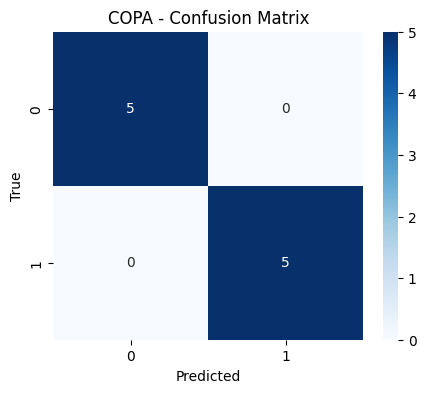

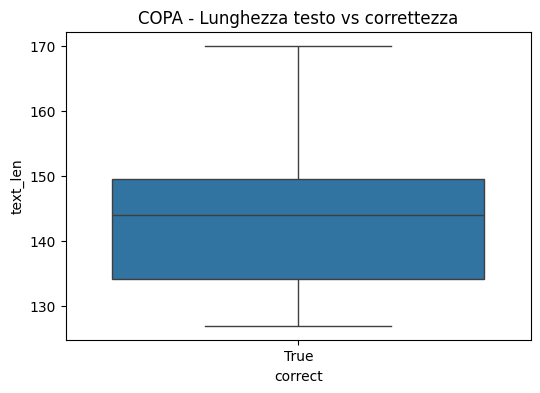

In [17]:
copa_df = pd.read_csv(tasks['COPA'], sep=";")
analyze_task_advanced(copa_df, 'Label', 'Label_no_ft', 'COPA', text_cols=['Premise','Choice_1','Choice_2'])

#### COPA Model directive


=== Analisi Avanzata: COPA ===
Confusion Matrix:
 [[4 1]
 [0 5]]

Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.80      0.89         5
           2       0.83      1.00      0.91         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10

MCC: 0.816


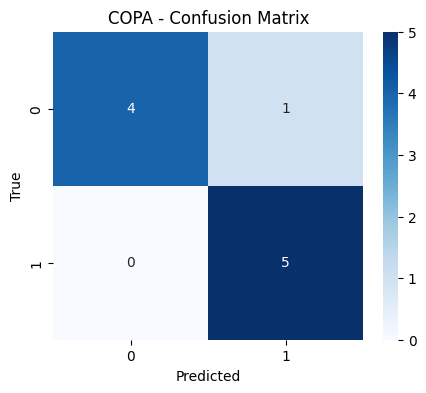

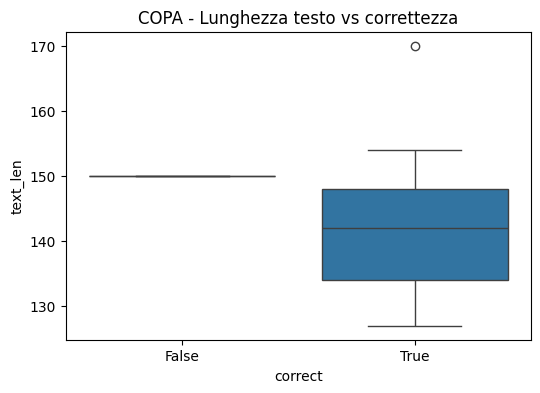

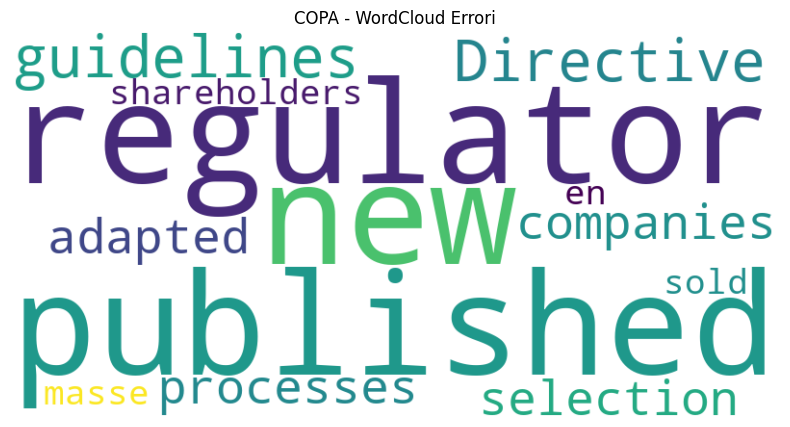

In [18]:
copa_df = pd.read_csv(tasks['COPA'], sep=";")
analyze_task_advanced(copa_df, 'Label', 'Label_directive', 'COPA', text_cols=['Premise','Choice_1','Choice_2'])

In [19]:
df_copa

,Premise,Choice_1,Choice_2,Label,Label_no_ft,Label_directive,Label_legends
0,The board of directors did not respect the gen...,The supervisory authority has applied a sanction.,The company has increased its dividends.,1,1,1,1
1,The company has introduced policies to promote...,Productivity has dropped.,The company's reputation has improved.,2,2,2,2
2,The regulator has published new guidelines on ...,The companies have adapted the selection proce...,The shareholders sold en masse.,1,1,2,1
3,A listed company ignored the provisions of the...,Sales in the sector have increased.,Public opinion has criticized governance.,2,2,2,2
4,The council has reached 40% of female presence.,The council has been reduced in size.,The company has complied with the directive.,2,2,2,2
5,The non-compliance with the quotas was reporte...,The company suffered reputational damage.,The council received an award.,1,1,1,1
6,A company has implemented female mentoring pro...,More women have reached leadership positions.,Quarterly earnings decreased for no reason.,1,1,1,1
7,The European Parliament has approved the direc...,The companies have laid off half of the techni...,The companies have gradually adapted.,2,2,2,2
8,The shareholders' meeting rejected the appoint...,"The company had to propose a new, more balance...",Employees went on strike for wage reasons.,1,1,1,1
9,The company has complied with the objectives o...,It has drastically reduced investments.,It has improved the image on the market.,2,2,2,2


#### COPA Model legends


=== Analisi Avanzata: COPA ===
Confusion Matrix:
 [[5 0]
 [0 5]]

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

MCC: 1.000


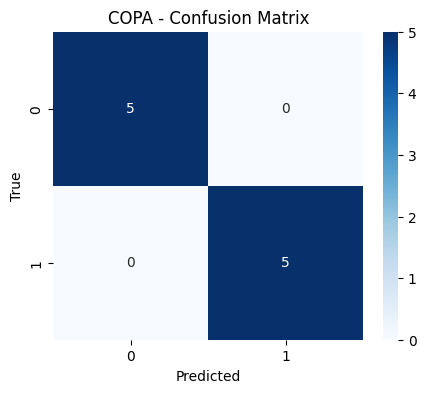

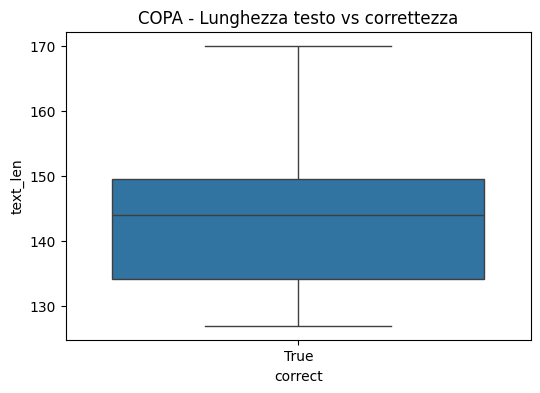

In [20]:
copa_df = pd.read_csv(tasks['COPA'], sep=";")
analyze_task_advanced(copa_df, 'Label', 'Label_legends', 'COPA', text_cols=['Premise','Choice_1','Choice_2'])

#### RTE - Legal Entailment Model no fine tuning

In [21]:
df_le['Hypothesis'][0]

'Companies must ensure that 40% of the board is composed of women.'


=== Analisi Avanzata: LE ===
Confusion Matrix:
 [[4 1]
 [0 5]]

Classification Report:
                 precision    recall  f1-score   support

    entailment       1.00      0.80      0.89         5
not_entailment       0.83      1.00      0.91         5

      accuracy                           0.90        10
     macro avg       0.92      0.90      0.90        10
  weighted avg       0.92      0.90      0.90        10

MCC: 0.816


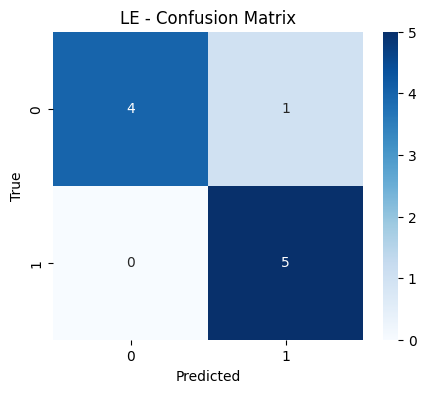

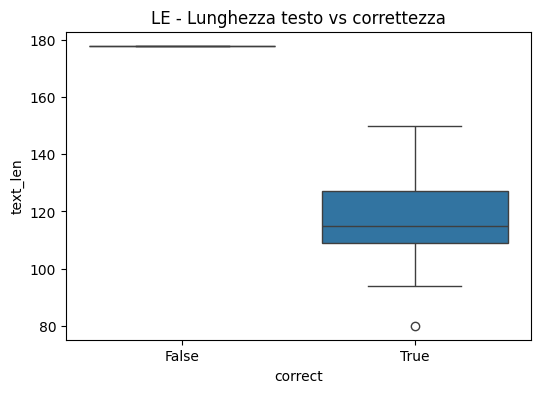

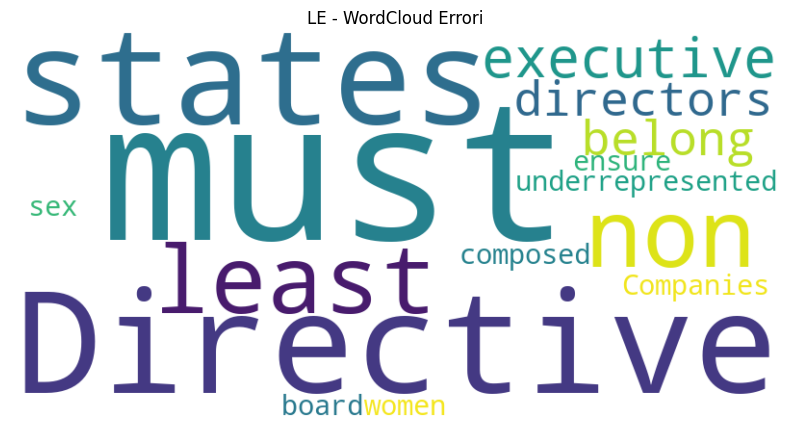

In [22]:
rte_df = pd.read_csv(tasks['LE'], sep=';')
analyze_task_advanced(rte_df, 'Label', 'Label_no_ft', 'LE', text_cols=['Premise','Hypothesis'])

#### RTE - Legal Entailment Model directive


=== Analisi Avanzata: LE ===
Confusion Matrix:
 [[4 1]
 [0 5]]

Classification Report:
                 precision    recall  f1-score   support

    entailment       1.00      0.80      0.89         5
not_entailment       0.83      1.00      0.91         5

      accuracy                           0.90        10
     macro avg       0.92      0.90      0.90        10
  weighted avg       0.92      0.90      0.90        10

MCC: 0.816


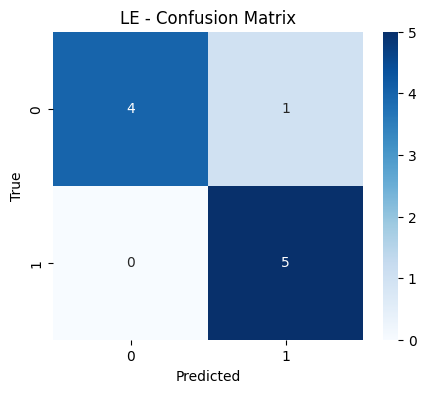

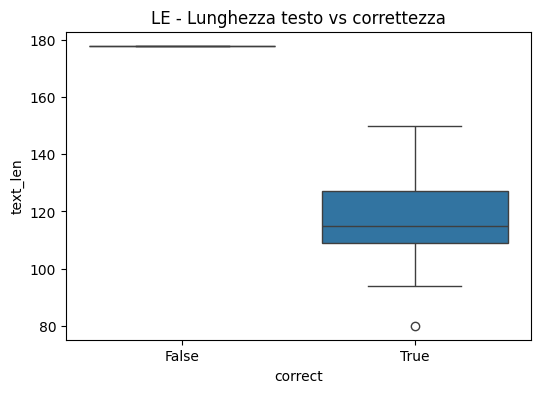

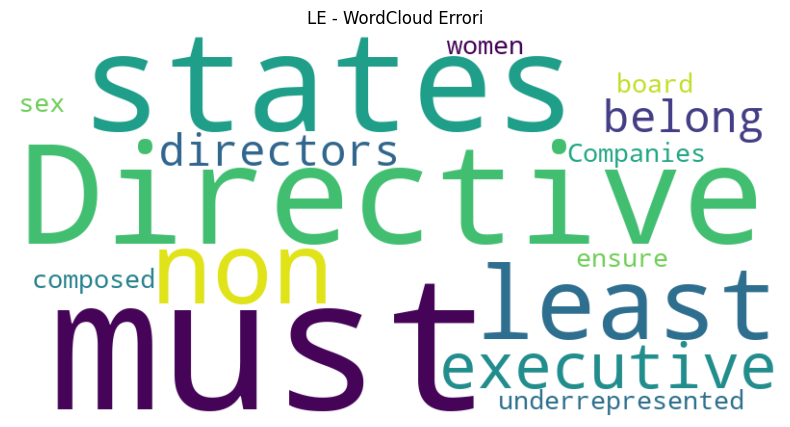

In [23]:
rte_df = pd.read_csv(tasks['LE'], sep=';')
analyze_task_advanced(rte_df, 'Label', 'Label_directive', 'LE', text_cols=['Premise','Hypothesis'])

In [24]:
df_le['Premise'][0]

'Directive 2022/2381 states that at least 40% of non-executive directors must belong to the underrepresented sex.'

#### RTE - Legal Entailment Model legends


=== Analisi Avanzata: LE ===
Confusion Matrix:
 [[4 1]
 [0 5]]

Classification Report:
                 precision    recall  f1-score   support

    entailment       1.00      0.80      0.89         5
not_entailment       0.83      1.00      0.91         5

      accuracy                           0.90        10
     macro avg       0.92      0.90      0.90        10
  weighted avg       0.92      0.90      0.90        10

MCC: 0.816


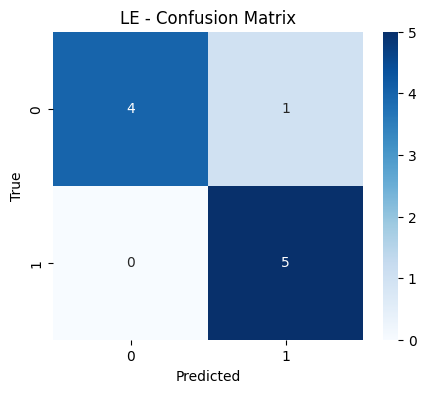

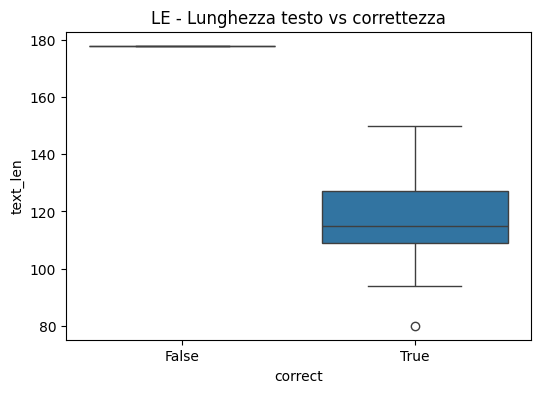

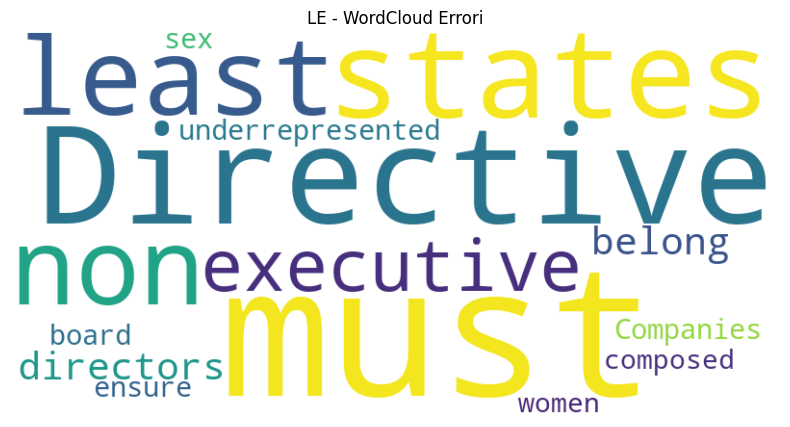

In [25]:
rte_df = pd.read_csv(tasks['LE'], sep=';')
analyze_task_advanced(rte_df, 'Label', 'Label_legends', 'LE', text_cols=['Premise','Hypothesis'])

In [26]:
df_le

,Premise,Hypothesis,Label,Label_no_ft,Label_directive,Label_legends
0,Directive 2022/2381 states that at least 40% o...,Companies must ensure that 40% of the board is...,entailment,not_entailment,not_entailment,not_entailment
1,The directive requires transparency in selecti...,Companies may appoint directors without public...,not_entailment,not_entailment,not_entailment,not_entailment
2,Member States must introduce sanctions for non...,A company that ignores the directive faces no ...,not_entailment,not_entailment,not_entailment,not_entailment
3,The directive only applies to companies listed...,Family-owned unlisted businesses must also com...,not_entailment,not_entailment,not_entailment,not_entailment
4,"If two candidates have equal qualifications, t...","In case of equal merit, a woman is favored if ...",entailment,entailment,entailment,entailment
5,The directive must be implemented by 2026.,Measures must be operational by 2026.,entailment,entailment,entailment,entailment
6,Member States must send periodic reports to th...,Governments must communicate progress to Bruss...,entailment,entailment,entailment,entailment
7,The directive does not change individual emplo...,The provisions affect individual employee cont...,not_entailment,not_entailment,not_entailment,not_entailment
8,The directive aims to improve corporate govern...,The goal is to strengthen transparency and boa...,entailment,entailment,entailment,entailment
9,The directive concerns gender balance on boards.,The regulation is focused on data protection.,not_entailment,not_entailment,not_entailment,not_entailment


#### Multi-RC Model no fine tuning


=== Analisi Avanzata: MultiRC - Answer 1 ===
Confusion Matrix:
 [[1 0]
 [0 9]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         9

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

MCC: 1.000


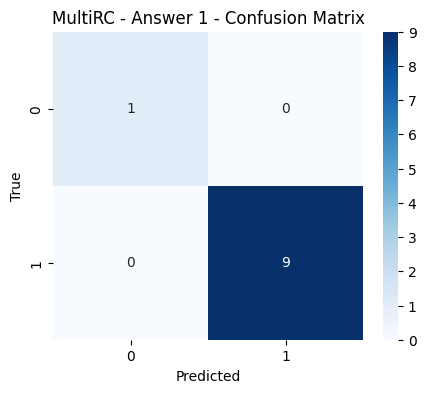

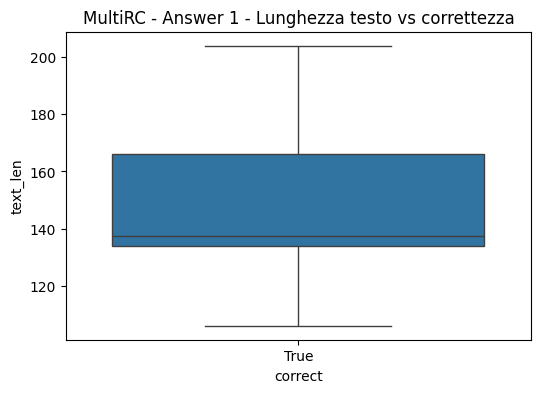


=== Analisi Avanzata: MultiRC - Answer 2 ===
Confusion Matrix:
 [[4 0]
 [0 6]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

MCC: 1.000


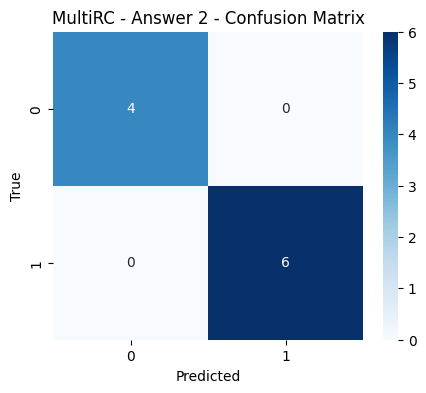

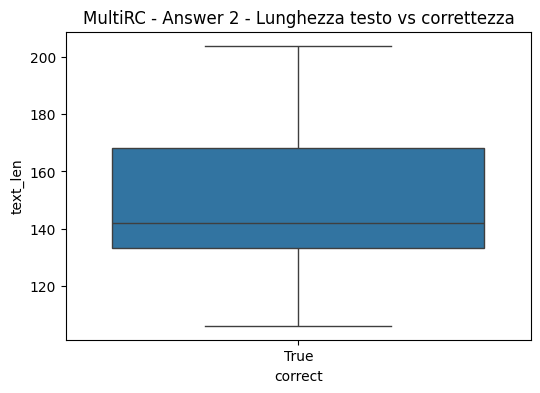

In [27]:
multi_df = pd.read_csv(tasks['MULTI_RC'], sep=';')
analyze_task_advanced(multi_df, 'Label_1', 'Label_1_no_ft', 'MultiRC - Answer 1', text_cols=['Passage','Question','Answer_1'])
analyze_task_advanced(multi_df, 'Label_2', 'Label_2_no_ft', 'MultiRC - Answer 2', text_cols=['Passage','Question','Answer_2'])

#### Multi-RC Model directive


=== Analisi Avanzata: MultiRC - Answer 1 ===
Confusion Matrix:
 [[1 0]
 [0 9]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         9

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

MCC: 1.000


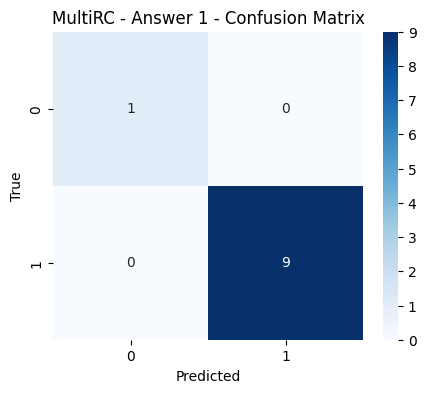

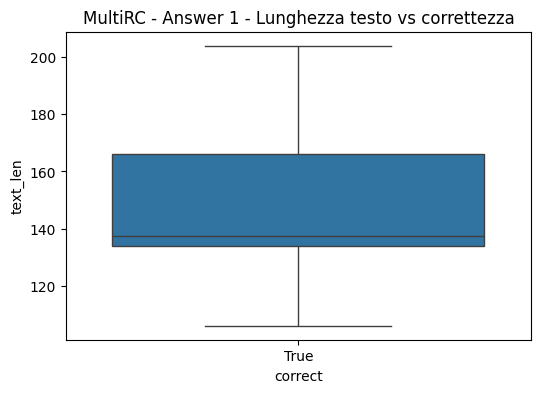


=== Analisi Avanzata: MultiRC - Answer 2 ===
Confusion Matrix:
 [[4 0]
 [1 5]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.83      0.91         6

    accuracy                           0.90        10
   macro avg       0.90      0.92      0.90        10
weighted avg       0.92      0.90      0.90        10

MCC: 0.816


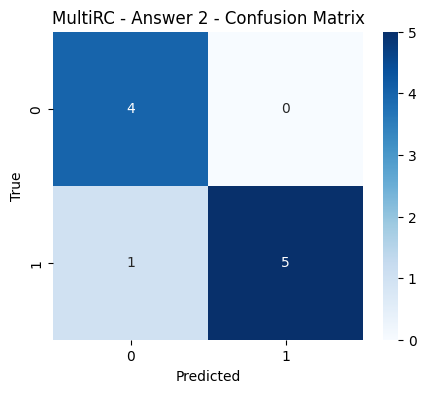

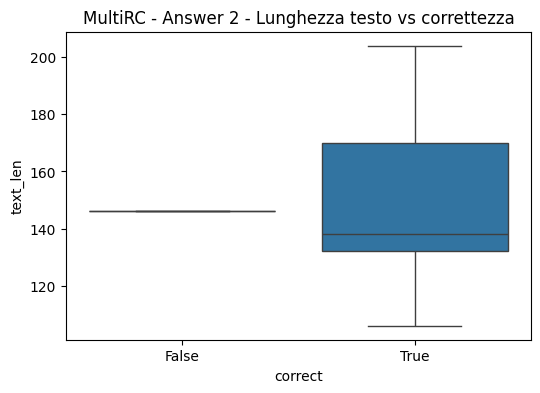

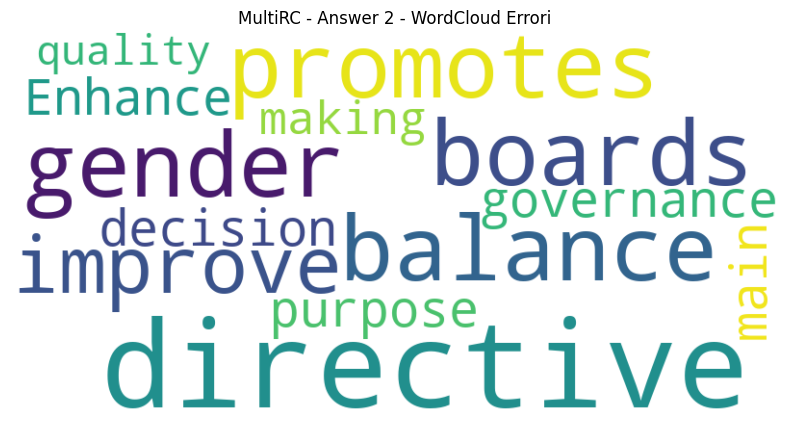

In [28]:
multi_df = pd.read_csv(tasks['MULTI_RC'], sep=';')
analyze_task_advanced(multi_df, 'Label_1', 'Label_1_directive', 'MultiRC - Answer 1', text_cols=['Passage','Question','Answer_1'])
analyze_task_advanced(multi_df, 'Label_2', 'Label_2_directive', 'MultiRC - Answer 2', text_cols=['Passage','Question','Answer_2'])

In [29]:
df_multirc

,Passage,Question,Answer_1,Answer_2,Label_1,Label_2,Label_1_no_ft,Label_2_no_ft,Label_1_directive,Label_2_directive,Label_1_legends,Label_2_legends
0,Directive 2022/2381 requires that at least 40%...,What is the minimum percentage for the underre...,40%,25%,1,0,1,0,1,0,1,0
1,"According to the directive, Member States must...",What happens if a company does not comply?,Sanctions are imposed.,Legal action may be initiated.,1,1,1,1,1,1,1,1
2,The directive applies to companies listed on r...,Which companies does the directive apply to?,Small unlisted companies.,Listed companies.,0,1,0,1,0,1,0,1
3,Member States must ensure that selection proce...,What is a requirement for selection procedures?,They must be transparent.,They must be merit-based.,1,1,1,1,1,1,1,1
4,"If two candidates have equal qualifications, t...",Who is favored in case of equal qualifications?,The candidate of the underrepresented sex.,The less experienced candidate.,1,0,1,0,1,0,1,0
5,The directive requires the rules to be impleme...,What is the deadline for implementation?,2026.,2035.,1,0,1,0,1,0,1,0
6,Member States must periodically report to the ...,What must Member States do?,Send periodic reports.,Provide compliance statistics.,1,1,1,1,1,1,1,1
7,Companies that meet the target may still impro...,What happens to compliant companies?,They can continue strengthening diversity.,They are excluded from the directive.,1,0,1,0,1,0,1,0
8,Failure to comply with the rules may negativel...,What is a consequence of non-compliance?,Reputational damage.,Financial penalties.,1,1,1,1,1,1,1,1
9,The directive promotes gender balance on board...,What is the main purpose of the directive?,Improve governance.,Enhance decision-making quality.,1,1,1,1,1,0,1,1


#### Multi-RC Model legends


=== Analisi Avanzata: MultiRC - Answer 1 ===
Confusion Matrix:
 [[1 0]
 [0 9]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         9

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

MCC: 1.000


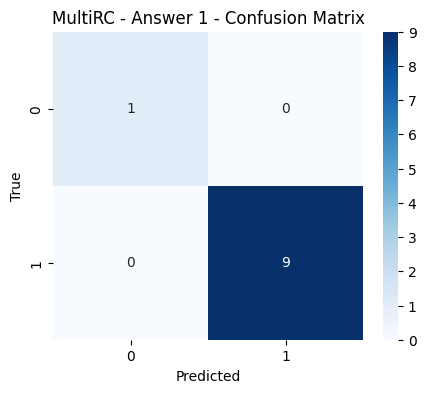

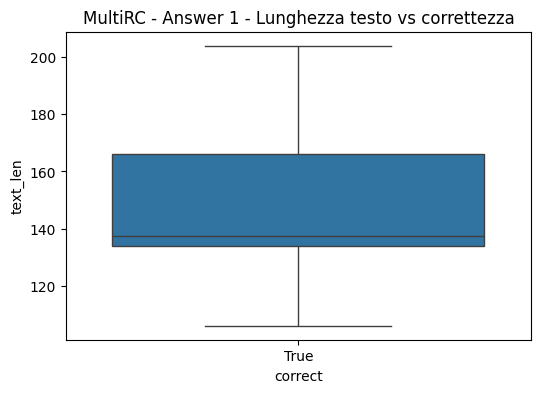


=== Analisi Avanzata: MultiRC - Answer 2 ===
Confusion Matrix:
 [[4 0]
 [0 6]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         6

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

MCC: 1.000


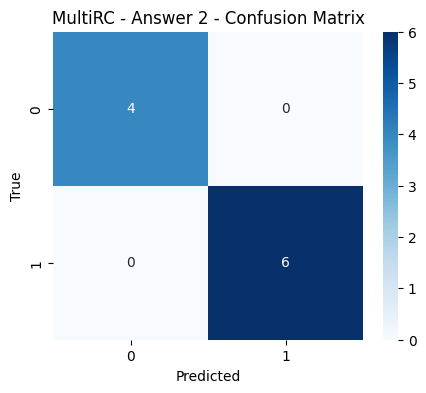

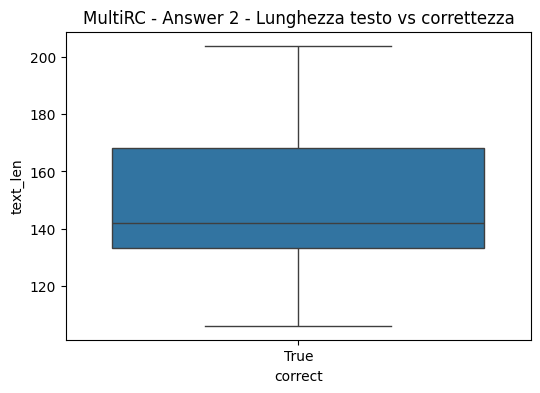

In [30]:
multi_df = pd.read_csv(tasks['MULTI_RC'], sep=';')
analyze_task_advanced(multi_df, 'Label_1', 'Label_1_legends', 'MultiRC - Answer 1', text_cols=['Passage','Question','Answer_1'])
analyze_task_advanced(multi_df, 'Label_2', 'Label_2_legends', 'MultiRC - Answer 2', text_cols=['Passage','Question','Answer_2'])

#### WIC Model no fine tuning


=== Analisi Avanzata: WiC ===
Confusion Matrix:
 [[5 0]
 [0 5]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

MCC: 1.000


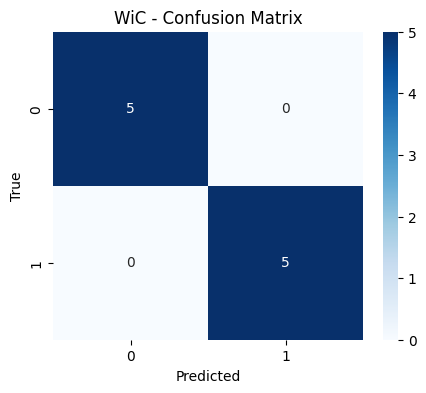

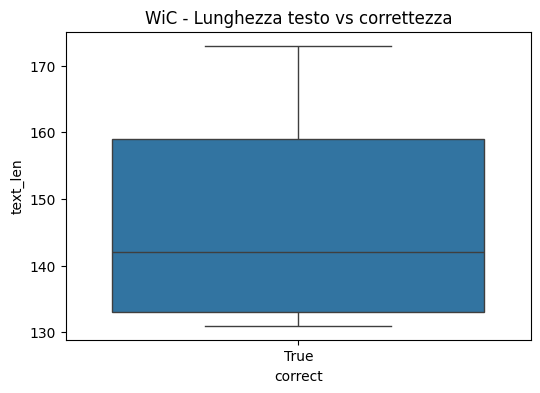

In [31]:
wic_df = pd.read_csv(tasks['WIC'], sep=';')
analyze_task_advanced(wic_df, 'Label', 'Label_no_ft', 'WiC', text_cols=['Sentence_1','Sentence_2','Word'])

In [32]:
wic_df

,Sentence_1,Sentence_2,Word,Label,Label_no_ft,Label_directive,Label_legends,text_combined,correct,text_len
0,The board promoted gender balance in appointme...,The gender of the candidate was clearly indica...,gender,1,1,1,1,The board promoted gender balance in appointme...,True,170
1,The manager showed great respect for the emplo...,The directive requires shareholders to show re...,respect,1,1,0,0,The manager showed great respect for the emplo...,True,173
2,Gender quotas were reached by the company in l...,The gender of the newborn was celebrated at home.,gender,0,0,1,0,Gender quotas were reached by the company in l...,True,132
3,The employee suffered discrimination due to la...,The company suffered sanctions for not meeting...,suffered,0,0,0,1,The employee suffered discrimination due to la...,True,153
4,The board of directors adopted new measures to...,The school board discussed unrelated matters a...,board,0,0,0,0,The board of directors adopted new measures to...,True,144
5,The role of the chairperson was crucial in imp...,His role in drafting the compliance report was...,role,1,1,1,1,The role of the chairperson was crucial in imp...,True,133
6,The selection of candidates ensured compliance...,Natural selection explains adaptation in biology.,selection,0,0,0,0,The selection of candidates ensured compliance...,True,133
7,The annual financial report included a section...,The report on gender representation was submit...,report,1,1,1,1,The annual financial report included a section...,True,161
8,The presence of women on boards increased afte...,The constant presence of auditors ensured tran...,presence,1,1,1,1,The presence of women on boards increased afte...,True,140
9,Gender balance was respected by appointing mor...,Financial balance was maintained despite restr...,balance,0,0,0,0,Gender balance was respected by appointing mor...,True,131


#### WiC Model directive


=== Analisi Avanzata: WiC ===
Confusion Matrix:
 [[4 1]
 [1 4]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.80      0.80      0.80         5

    accuracy                           0.80        10
   macro avg       0.80      0.80      0.80        10
weighted avg       0.80      0.80      0.80        10

MCC: 0.600


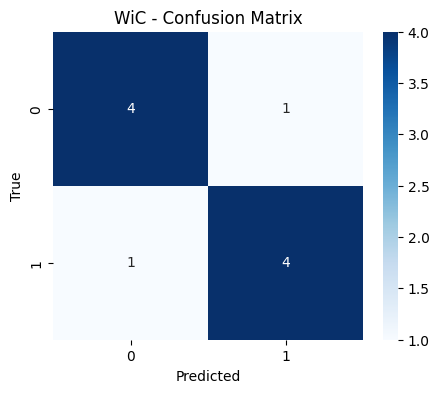

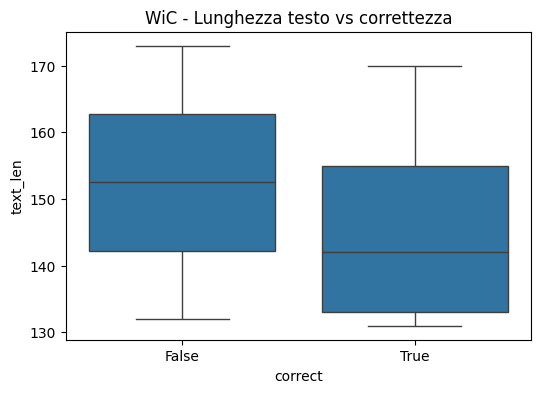

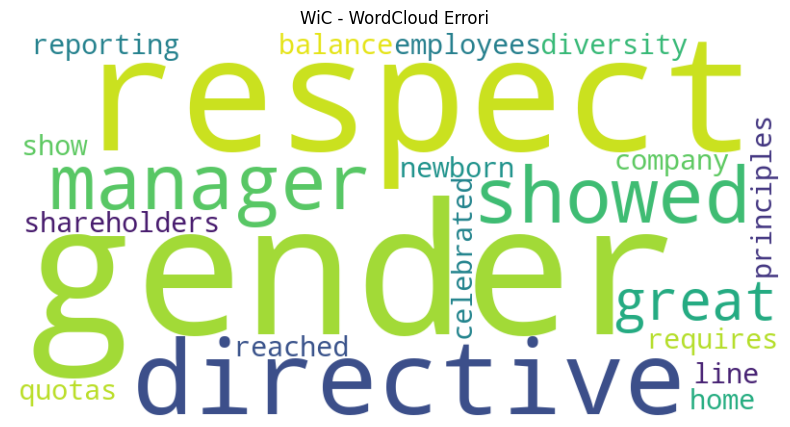

In [33]:
wic_df = pd.read_csv(tasks['WIC'], sep=';')
analyze_task_advanced(wic_df, 'Label', 'Label_directive', 'WiC', text_cols=['Sentence_1','Sentence_2','Word'])

#### WiC Model legends


=== Analisi Avanzata: WiC ===
Confusion Matrix:
 [[4 1]
 [1 4]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.80      0.80      0.80         5

    accuracy                           0.80        10
   macro avg       0.80      0.80      0.80        10
weighted avg       0.80      0.80      0.80        10

MCC: 0.600


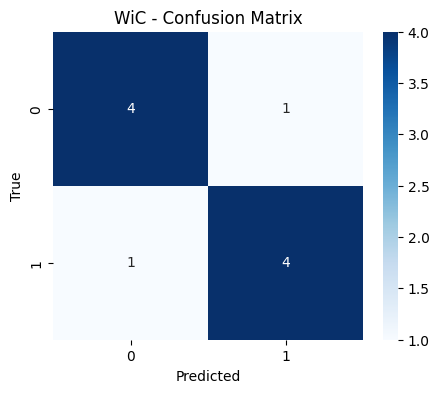

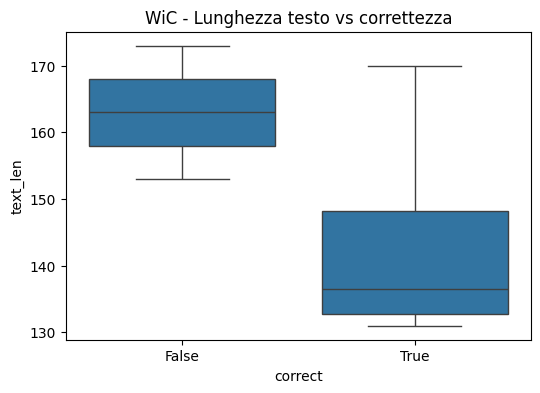

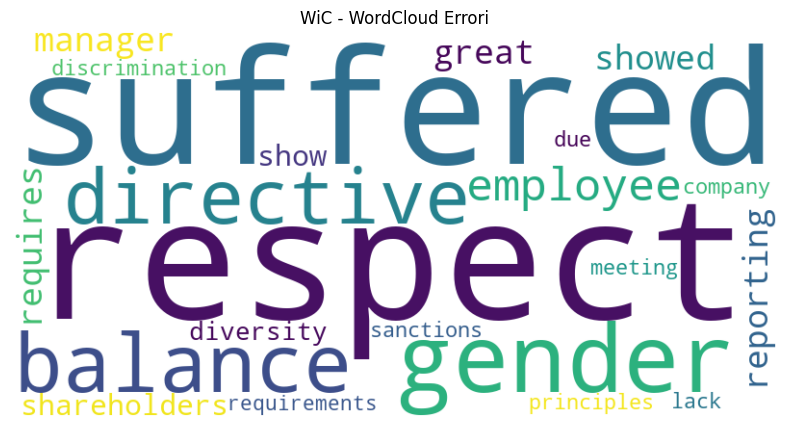

In [34]:
wic_df = pd.read_csv(tasks['WIC'], sep=';')
analyze_task_advanced(wic_df, 'Label', 'Label_legends', 'WiC', text_cols=['Sentence_1','Sentence_2','Word'])

### LIME analysis

In [35]:
def make_fake_predict_proba(df, model_col, input_col, class_names):
    """
    Restituisce una funzione predict_proba-like per LIME.
    Usa le label predette dal dataset salvato su CSV.
    """
    def fake_predict_proba(texts):
        results = []
        for t in texts:
            idx_match = df[df[input_col] == t].index
            if len(idx_match) == 0:
                # fallback: probabilità uniforme
                results.append([1/len(class_names)]*len(class_names))
            else:
                pred = df.loc[idx_match[0], model_col]
                probs = [1.0 if c == pred else 0.0 for c in class_names]
                results.append(probs)
        return np.array(results)
    return fake_predict_proba


def build_input(row, task):
    if task == "COPA":
        return f"Premise: {row['Premise']}\nChoice_1: {row['Choice_1']}\nChoice_2: {row['Choice_2']}"
    elif task == "RTE":
        return f"Premise: {row['Premise']}\nHypothesis: {row['Hypothesis']}"
    elif task == "MultiRC":
        return f"Passage: {row['Passage']}\nQuestion: {row['Question']}\nAnswer_1: {row['Answer_1']}\nAnswer_2: {row['Answer_2']}"
    elif task == "WiC":
        return f"Sentence_1: {row['Sentence_1']}\nSentence_2: {row['Sentence_2']}\nWord: {row['Word']}"
    else:
        raise ValueError(f"Task {task} non supportato.")


TASK_CLASSES = {
    "COPA": [1, 2],
    "RTE": ["entailment", "not_entailment"],
    "MultiRC": [1, 0],
    "WiC": [1, 0]
}


def explain_task(df, task, model_col="Label", max_examples=3):
    """
    df: dataframe con dati del task
    task: "COPA", "RTE", "MultiRC" o "WiC"
    model_col: colonna con le label predette dal modello
    """
    # Costruisci input colonna
    df = df.copy()
    df["input_text"] = df.apply(lambda row: build_input(row, task), axis=1)

    # Definisci classi
    class_names = TASK_CLASSES[task]

    # Funzione predict_proba
    fake_predict_proba = make_fake_predict_proba(df, model_col, "input_text", class_names)

    # Spiegatore
    explainer = LimeTextExplainer(class_names=class_names)

    for idx in range(min(max_examples, len(df))):
        text = df.iloc[idx]["input_text"]

        exp = explainer.explain_instance(text, fake_predict_proba, num_features=10, labels=[0,1])

        print("="*40)
        print(f"Task: {task} - Esempio {idx}")
        print("Input:", text)
        print("Predizione:", df.iloc[idx][model_col])
        print("Spiegazione (as list):")
        print(exp.as_list())
        
        # Visualizza grafico per la label predetta
        label_index = class_names.index(df.iloc[idx][model_col])
        fig = exp.as_pyplot_figure(label_index)
        plt.show()


### COPA

Task: COPA - Esempio 0
Input: Premise: The board of directors did not respect the gender quotas.
Choice_1: The supervisory authority has applied a sanction.
Choice_2: The company has increased its dividends.
Predizione: 1
Spiegazione (as list):
[(np.str_('sanction'), -0.00015088978033018022), (np.str_('applied'), -0.00014905080798686623), (np.str_('company'), -0.00014697733755484994), (np.str_('has'), -0.00014381115823337422), (np.str_('supervisory'), -0.00013845961365631872), (np.str_('dividends'), -0.00013748080661935978), (np.str_('increased'), -0.0001368666984591226), (np.str_('board'), -0.00013382593176101013), (np.str_('its'), -0.00013251470650407638), (np.str_('directors'), -0.00012471274251468978)]


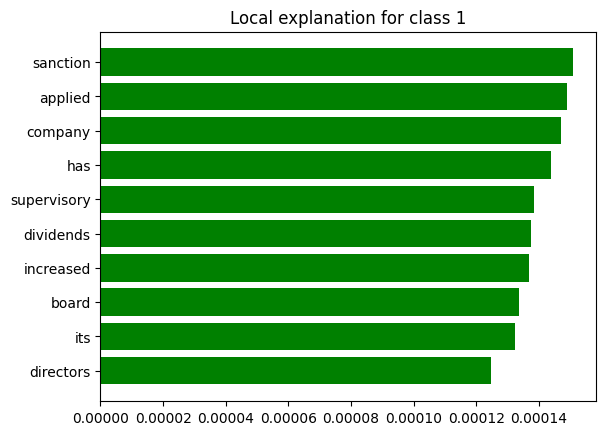

Task: COPA - Esempio 1
Input: Premise: The company has introduced policies to promote gender balance.
Choice_1: Productivity has dropped.
Choice_2: The company's reputation has improved.
Predizione: 2
Spiegazione (as list):
[(np.str_('introduced'), 0.00017648090233834642), (np.str_('reputation'), 0.00015782458708084554), (np.str_('improved'), 0.0001536149521430669), (np.str_('Choice_2'), 0.00015360845974776033), (np.str_('company'), 0.00015084172605391445), (np.str_('dropped'), 0.00014798805284654506), (np.str_('has'), 0.0001479049003247491), (np.str_('Premise'), 0.0001475418171563077), (np.str_('s'), 0.0001457040688395763), (np.str_('to'), 0.00013536781647405024)]


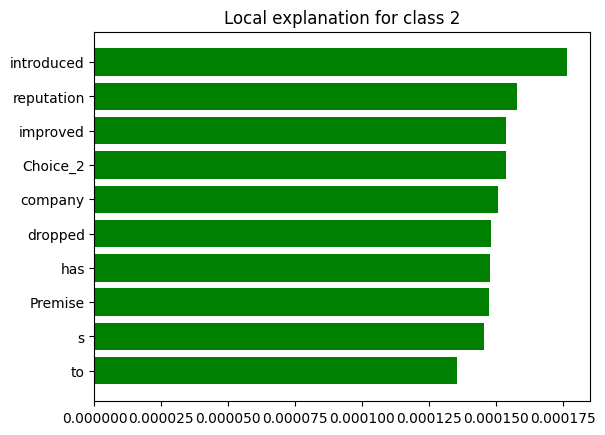

Task: COPA - Esempio 2
Input: Premise: The regulator has published new guidelines on Directive 2022/2381.
Choice_1: The companies have adapted the selection processes.
Choice_2: The shareholders sold en masse.
Predizione: 2
Spiegazione (as list):
[(np.str_('have'), 0.00014644003724001534), (np.str_('2022'), 0.00013847152676429807), (np.str_('masse'), 0.00013750619845690954), (np.str_('The'), 0.0001367124448909193), (np.str_('guidelines'), 0.00013296122425685009), (np.str_('companies'), 0.00013036639176518196), (np.str_('en'), 0.00012834244062163226), (np.str_('sold'), 0.00012583068479006076), (np.str_('selection'), 0.00012511037655976476), (np.str_('processes'), 0.00011644289558612552)]


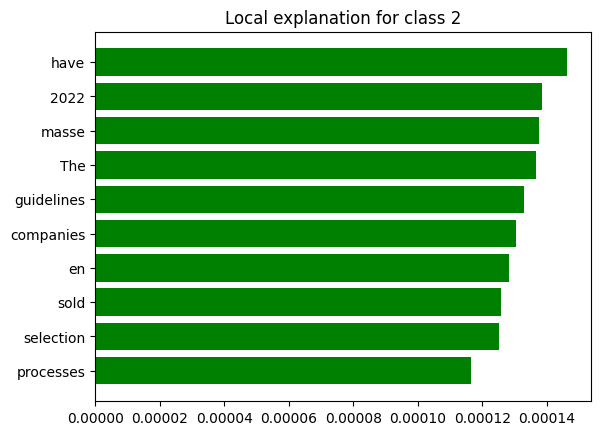

In [36]:
explain_task(df_copa, task="COPA", model_col="Label_directive")

### LE

Task: RTE - Esempio 0
Input: Premise: Directive 2022/2381 states that at least 40% of non-executive directors must belong to the underrepresented sex.
Hypothesis: Companies must ensure that 40% of the board is composed of women.
Predizione: not_entailment
Spiegazione (as list):
[(np.str_('of'), 0.00013894395739379872), (np.str_('states'), 0.00013783437671317664), (np.str_('40'), 0.000135557241277912), (np.str_('is'), 0.00013295185607467883), (np.str_('ensure'), 0.00013199120425123287), (np.str_('women'), 0.00013070972587553794), (np.str_('Hypothesis'), 0.00013011035723025976), (np.str_('belong'), 0.00012998291340378282), (np.str_('2022'), 0.00012981466860537776), (np.str_('composed'), 0.00012350430423271172)]


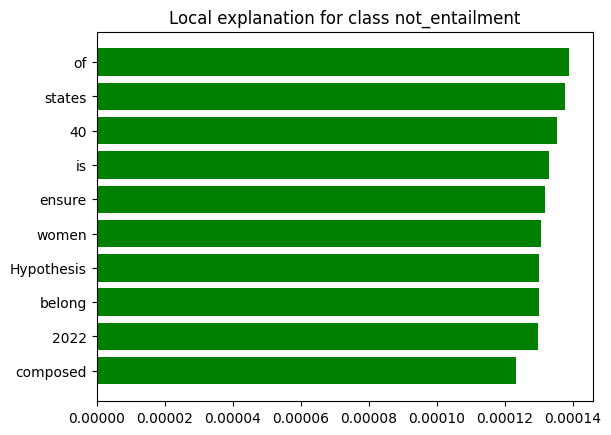

Task: RTE - Esempio 1
Input: Premise: The directive requires transparency in selection processes.
Hypothesis: Companies may appoint directors without public criteria.
Predizione: not_entailment
Spiegazione (as list):
[(np.str_('processes'), 0.0001577585935908473), (np.str_('directors'), 0.00015775013134761606), (np.str_('transparency'), 0.00015694400432339652), (np.str_('requires'), 0.0001509198092754085), (np.str_('The'), 0.0001505995374693667), (np.str_('without'), 0.0001454058213727942), (np.str_('criteria'), 0.0001446119179822833), (np.str_('may'), 0.0001425923100176619), (np.str_('directive'), 0.0001399455055968594), (np.str_('Premise'), 0.0001369830484207422)]


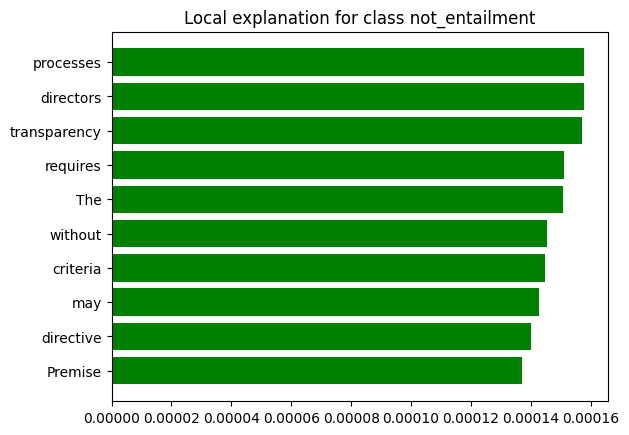

Task: RTE - Esempio 2
Input: Premise: Member States must introduce sanctions for non-compliant companies.
Hypothesis: A company that ignores the directive faces no consequences.
Predizione: not_entailment
Spiegazione (as list):
[(np.str_('the'), 0.00015309700915368203), (np.str_('company'), 0.00013961298013946054), (np.str_('A'), 0.00013773170715215897), (np.str_('non'), 0.00013732657681888682), (np.str_('no'), 0.00013725332122041845), (np.str_('sanctions'), 0.00013686889096670523), (np.str_('introduce'), 0.00013686648490689553), (np.str_('faces'), 0.00013199065833425358), (np.str_('Hypothesis'), 0.00012862164794395285), (np.str_('States'), 0.00012808923216059396)]


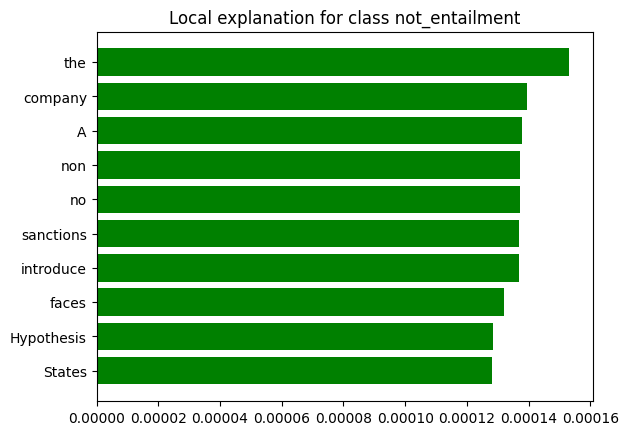

In [37]:
explain_task(df_le, task="RTE", model_col="Label_directive")

In [38]:
def explain_LIME_aggregated(df, model_cols, task, max_examples=5):
    """
    Crea 2 grafici complessivi (uno per entailment e uno per not_entailment),
    aggregando i risultati di più modelli (con barre affiancate).
    
    df : pandas.DataFrame con i dati
    model_cols : lista con i nomi delle colonne dei modelli, es. ["no_ft","directive","legends"]
    max_examples : quanti esempi usare per calcolare l'aggregazione
    """

    # Legal Entailment ha stessa struttura RTE
    class_names = TASK_CLASSES[task]  # ["entailment", "not_entailment"]

    # Costruisci input text
    df = df.copy()
    df["input_text"] = df.apply(lambda row: build_input(row, task), axis=1)

    explainer = LimeTextExplainer(class_names=class_names)

    # Contenitori: {classe: {modello: {feat: peso medio}}}
    agg_exp = {c: {m: {} for m in model_cols} for c in class_names}

    # Itera su esempi
    for idx in range(min(max_examples, len(df))):
        text = df.iloc[idx]["input_text"]

        for model_col in model_cols:
            fake_predict_proba = make_fake_predict_proba(df, model_col, "input_text", class_names)
            exp = explainer.explain_instance(text, fake_predict_proba, num_features=10, labels=[0,1])

            pred_label = df.iloc[idx][model_col]

            for label in class_names:
                for feat, weight in exp.as_list(label=class_names.index(label)):
                    agg_exp[label][model_col][feat] = agg_exp[label][model_col].get(feat, 0) + weight

    # Media dei pesi
    for label in class_names:
        for model_col in model_cols:
            for feat in agg_exp[label][model_col]:
                agg_exp[label][model_col][feat] /= max_examples

    # ---- Visualizzazione finale: 2 grafici aggregati ----
    colors = {model_cols[0]:"#1f77b4", model_cols[1]:"#ff7f0e", model_cols[2]:"#2ca02c"}

    for label in class_names:
        # Trova top 10 feature globali (sommando modelli)
        feat_scores = {}
        for model_col in model_cols:
            for feat, w in agg_exp[label][model_col].items():
                feat_scores[feat] = feat_scores.get(feat, 0) + abs(w)
        top_feats = sorted(feat_scores.keys(), key=lambda f: feat_scores[f], reverse=True)[:10]

        x = np.arange(len(top_feats))
        width = 0.25

        plt.figure(figsize=(10,6))
        for i, model_col in enumerate(model_cols):
            vals = [agg_exp[label][model_col].get(f, 0) for f in top_feats]
            plt.bar(x + i*width, vals, width, label=model_col, color=colors[model_col])

        plt.xticks(x + width, top_feats, rotation=45, ha="right")
        plt.ylabel("Peso medio")
        plt.title(f"Importanza media feature ({label})")
        plt.legend()
        plt.tight_layout()
        plt.show()


In [39]:
df_le.head(1)

,Premise,Hypothesis,Label,Label_no_ft,Label_directive,Label_legends
0,Directive 2022/2381 states that at least 40% o...,Companies must ensure that 40% of the board is...,entailment,not_entailment,not_entailment,not_entailment


In [40]:
df_le_error = df_le.head(1)

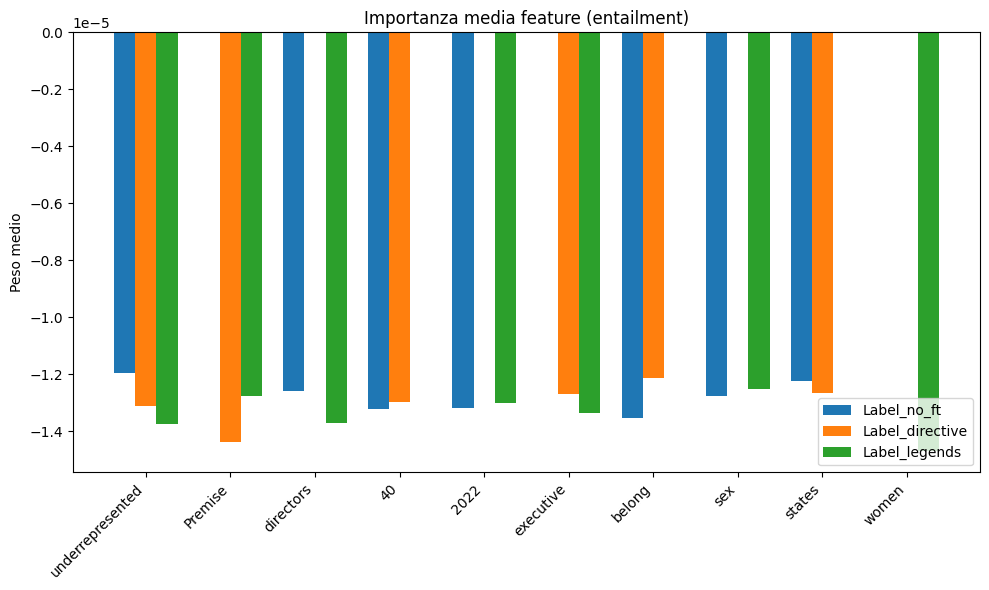

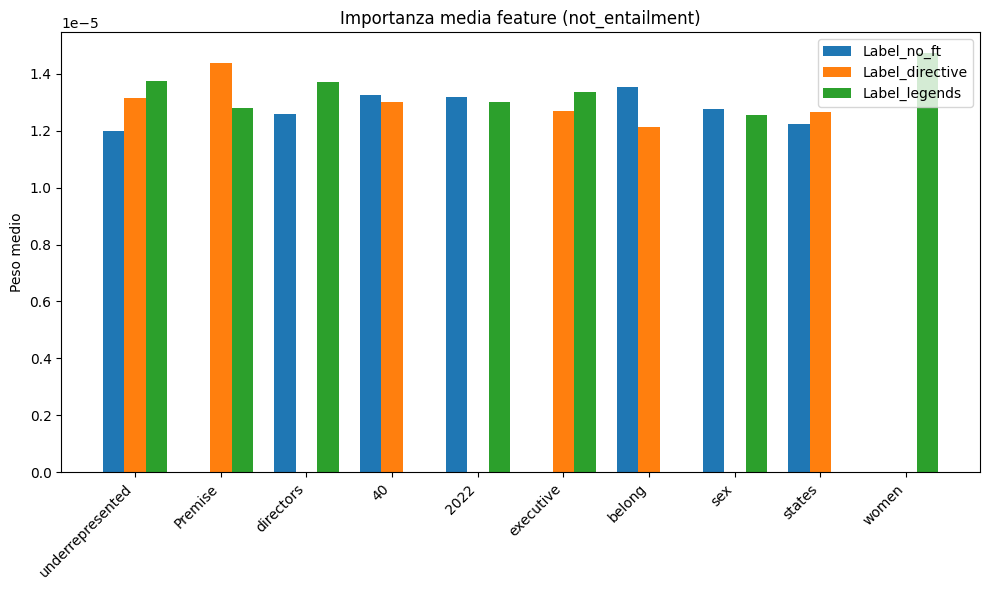

In [41]:
explain_LIME_aggregated(df_le_error, ["Label_no_ft", "Label_directive", "Label_legends"], "RTE", 10)

### MultiRC

Task: MultiRC - Esempio 0
Input: Passage: Directive 2022/2381 requires that at least 40% of non-executive directors in listed companies belong to the underrepresented sex.
Question: What is the minimum percentage for the underrepresented sex on boards?
Answer_1: 40%
Answer_2: 25%
Predizione: 1
Spiegazione (as list):
[(np.str_('at'), -0.00014011535424577254), (np.str_('in'), -0.00013495135262247247), (np.str_('belong'), -0.00013259083875121806), (np.str_('25'), -0.0001319239728610723), (np.str_('requires'), -0.0001308975608693556), (np.str_('Directive'), -0.00012139891643068972), (np.str_('minimum'), -0.00012058432689168646), (np.str_('to'), -0.00011954511953330447), (np.str_('Answer_2'), -0.000119340426392904), (np.str_('2381'), -0.00011232050808118599)]


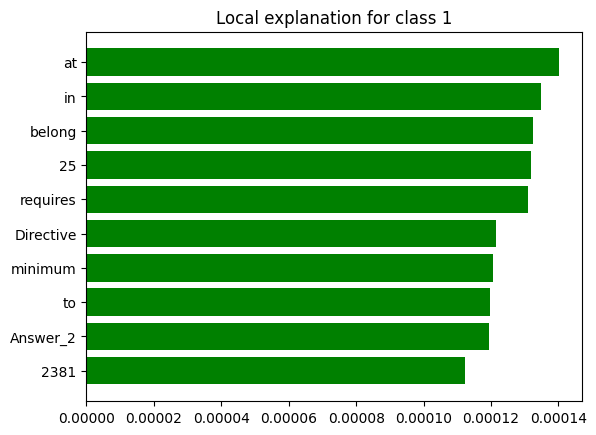

Task: MultiRC - Esempio 1
Input: Passage: According to the directive, Member States must adopt sanctions in case of non-compliance.
Question: What happens if a company does not comply?
Answer_1: Sanctions are imposed.
Answer_2: Legal action may be initiated.
Predizione: 1
Spiegazione (as list):
[(np.str_('States'), -0.00013213237465694121), (np.str_('comply'), -0.00012739508061499939), (np.str_('Question'), -0.00012637402220553914), (np.str_('if'), -0.00012407644296451442), (np.str_('Legal'), -0.00012373060311530331), (np.str_('initiated'), -0.00012262924778245408), (np.str_('are'), -0.00012239241767288982), (np.str_('company'), -0.00012088203505608294), (np.str_('Answer_2'), -0.00012048221695870231), (np.str_('Sanctions'), -0.00011259968976034371)]


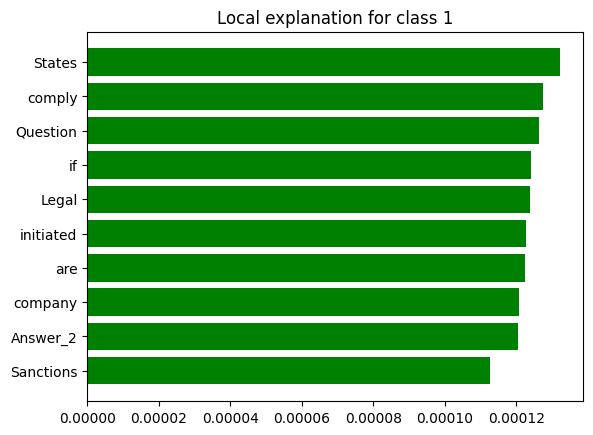

Task: MultiRC - Esempio 2
Input: Passage: The directive applies to companies listed on regulated EU markets.
Question: Which companies does the directive apply to?
Answer_1: Small unlisted companies.
Answer_2: Listed companies.
Predizione: 0
Spiegazione (as list):
[(np.str_('Answer_2'), 0.00014625180962780116), (np.str_('companies'), 0.00014358817661735756), (np.str_('markets'), 0.00014149947115134977), (np.str_('listed'), 0.0001412502011553149), (np.str_('apply'), 0.0001356404069819431), (np.str_('EU'), 0.00013541970943057384), (np.str_('The'), 0.00013540769990097123), (np.str_('Question'), 0.0001334926076141016), (np.str_('directive'), 0.00013121138158281765), (np.str_('regulated'), 0.000128816496704011)]


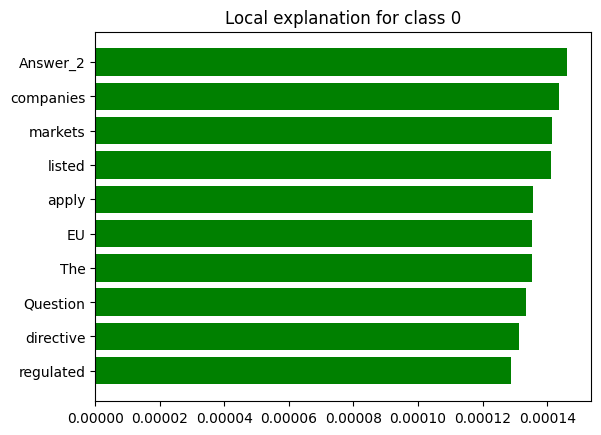

In [42]:
explain_task(df_multirc, task="MultiRC", model_col="Label_1_directive")

In [43]:
df_multirc

,Passage,Question,Answer_1,Answer_2,Label_1,Label_2,Label_1_no_ft,Label_2_no_ft,Label_1_directive,Label_2_directive,Label_1_legends,Label_2_legends
0,Directive 2022/2381 requires that at least 40%...,What is the minimum percentage for the underre...,40%,25%,1,0,1,0,1,0,1,0
1,"According to the directive, Member States must...",What happens if a company does not comply?,Sanctions are imposed.,Legal action may be initiated.,1,1,1,1,1,1,1,1
2,The directive applies to companies listed on r...,Which companies does the directive apply to?,Small unlisted companies.,Listed companies.,0,1,0,1,0,1,0,1
3,Member States must ensure that selection proce...,What is a requirement for selection procedures?,They must be transparent.,They must be merit-based.,1,1,1,1,1,1,1,1
4,"If two candidates have equal qualifications, t...",Who is favored in case of equal qualifications?,The candidate of the underrepresented sex.,The less experienced candidate.,1,0,1,0,1,0,1,0
5,The directive requires the rules to be impleme...,What is the deadline for implementation?,2026.,2035.,1,0,1,0,1,0,1,0
6,Member States must periodically report to the ...,What must Member States do?,Send periodic reports.,Provide compliance statistics.,1,1,1,1,1,1,1,1
7,Companies that meet the target may still impro...,What happens to compliant companies?,They can continue strengthening diversity.,They are excluded from the directive.,1,0,1,0,1,0,1,0
8,Failure to comply with the rules may negativel...,What is a consequence of non-compliance?,Reputational damage.,Financial penalties.,1,1,1,1,1,1,1,1
9,The directive promotes gender balance on board...,What is the main purpose of the directive?,Improve governance.,Enhance decision-making quality.,1,1,1,1,1,0,1,1


In [44]:
df_multirc_error = df_multirc.tail(1)

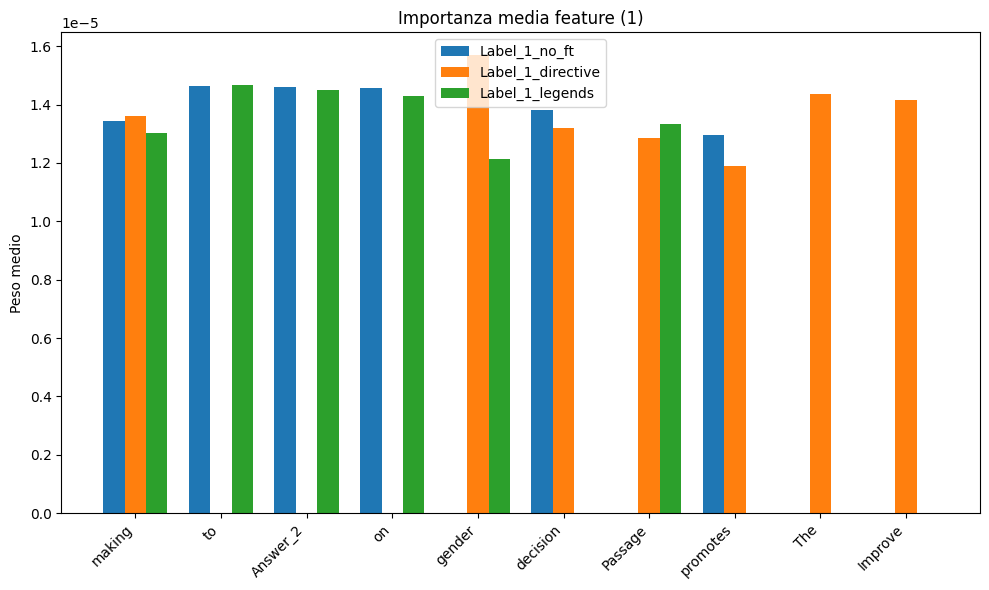

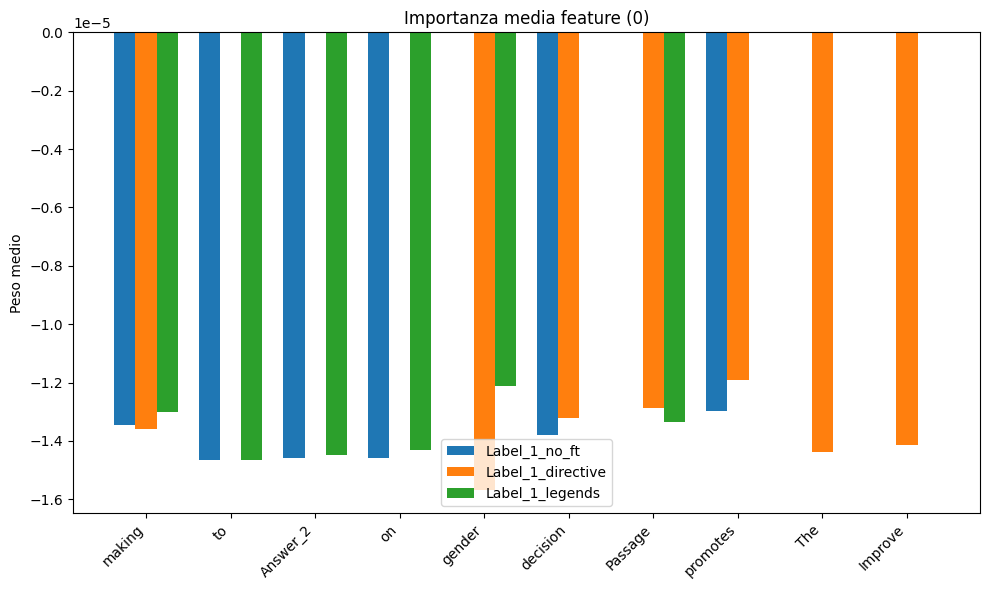

In [45]:
explain_LIME_aggregated(df_multirc_error, ["Label_1_no_ft", "Label_1_directive", "Label_1_legends"], "MultiRC", 10)

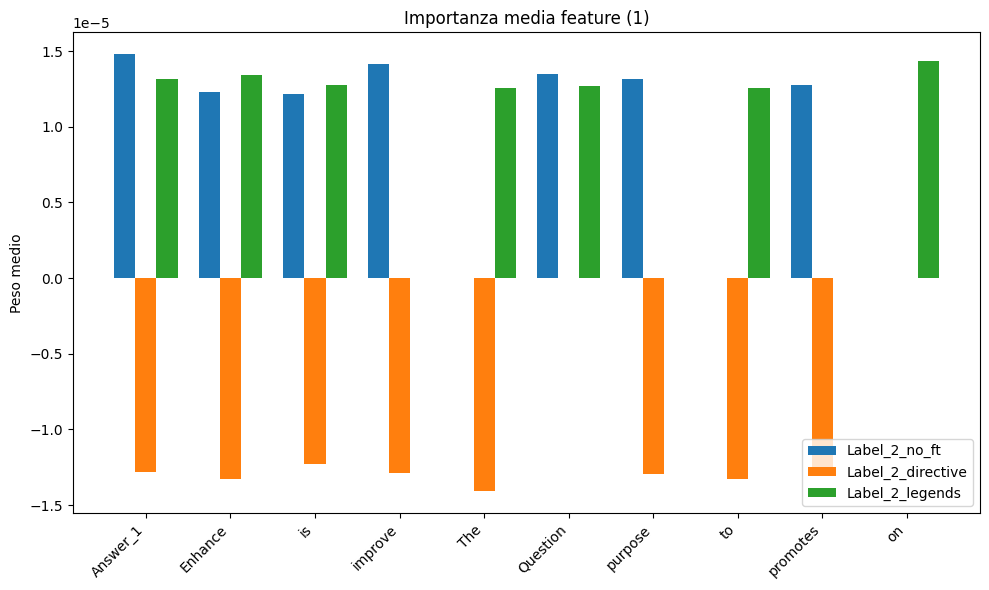

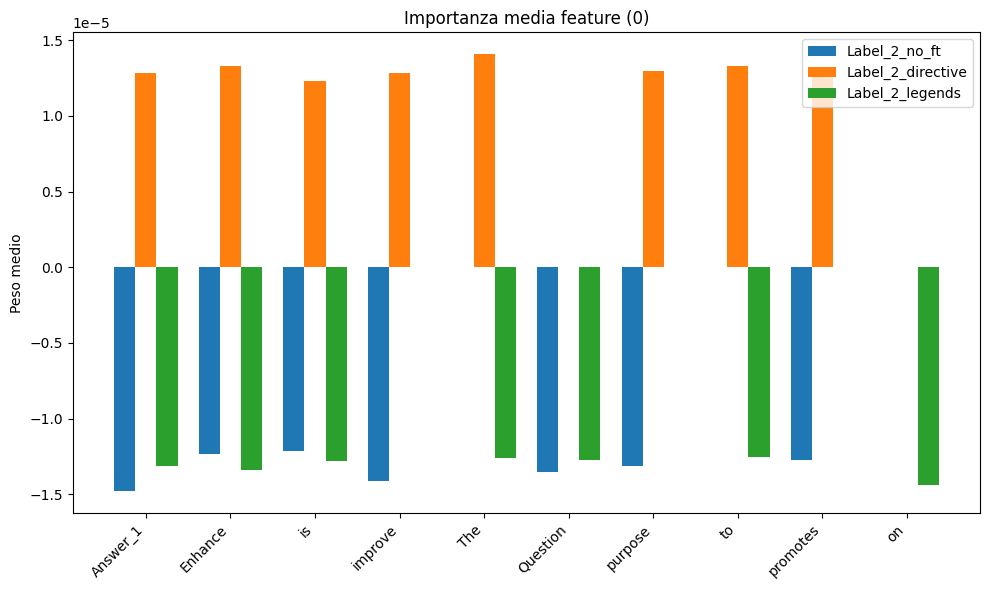

In [46]:
explain_LIME_aggregated(df_multirc_error, ["Label_2_no_ft", "Label_2_directive", "Label_2_legends"], "MultiRC", 10)

### WiC

Task: WiC - Esempio 0
Input: Sentence_1: The board promoted gender balance in appointments, following the EU 2022/2381 directive.
Sentence_2: The gender of the candidate was clearly indicated on the application form.
Word: gender
Predizione: 1
Spiegazione (as list):
[(np.str_('of'), -0.00014177894371165218), (np.str_('clearly'), -0.00014005555368072598), (np.str_('Sentence_2'), -0.00013776472187663097), (np.str_('indicated'), -0.0001374528588767385), (np.str_('form'), -0.00013512502940816033), (np.str_('The'), -0.00013447122083190888), (np.str_('the'), -0.00013293544714768445), (np.str_('on'), -0.00013259826418442436), (np.str_('Sentence_1'), -0.00013005789075333827), (np.str_('appointments'), -0.00012636210881828412)]


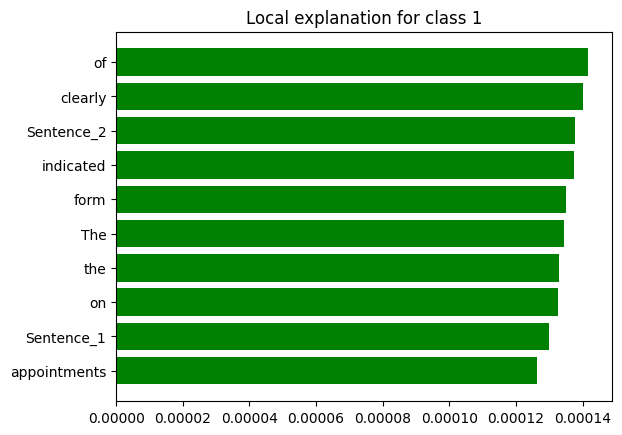

Task: WiC - Esempio 1
Input: Sentence_1: The manager showed great respect for the employees during the gender balance reporting.
Sentence_2: The directive requires shareholders to show respect for diversity principles.
Word: respect
Predizione: 0
Spiegazione (as list):
[(np.str_('show'), 0.00015906205463620728), (np.str_('shareholders'), 0.00015349668328938464), (np.str_('Word'), 0.00014741981077935054), (np.str_('respect'), 0.00014728615345898692), (np.str_('reporting'), 0.00013263084688571068), (np.str_('gender'), 0.0001325267867000895), (np.str_('principles'), 0.0001322686542425338), (np.str_('Sentence_2'), 0.00013142665599845876), (np.str_('balance'), 0.0001295338372085943), (np.str_('diversity'), 0.00012847740169842284)]


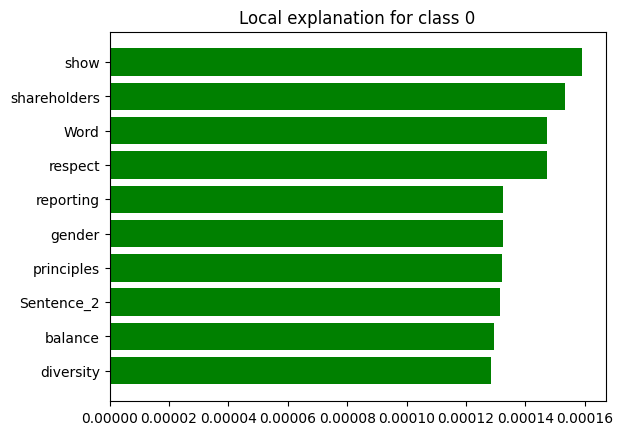

Task: WiC - Esempio 2
Input: Sentence_1: Gender quotas were reached by the company in line with Directive 2022/2381.
Sentence_2: The gender of the newborn was celebrated at home.
Word: gender
Predizione: 1
Spiegazione (as list):
[(np.str_('Gender'), -0.0001540984963812282), (np.str_('in'), -0.0001450061427944524), (np.str_('2381'), -0.00014388547258156124), (np.str_('line'), -0.00014191759036965583), (np.str_('Sentence_1'), -0.00013202347636904563), (np.str_('by'), -0.00012811001000693345), (np.str_('the'), -0.0001274452286824591), (np.str_('reached'), -0.00012619024956666525), (np.str_('were'), -0.00012292034484179653), (np.str_('gender'), -0.00012135820000007661)]


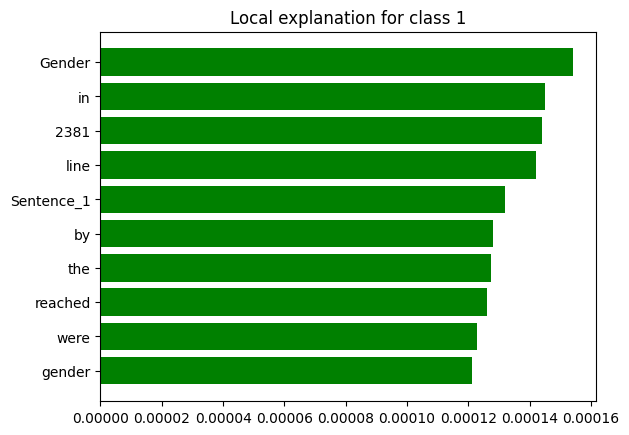

In [47]:
explain_task(df_wic, task="WiC", model_col="Label_directive")

In [48]:
df_wic_error = df_wic[1:4]

In [59]:
df_wic_error

,Sentence_1,Sentence_2,Word,Label,Label_no_ft,Label_directive,Label_legends
1,The manager showed great respect for the emplo...,The directive requires shareholders to show re...,respect,1,1,0,0
2,Gender quotas were reached by the company in l...,The gender of the newborn was celebrated at home.,gender,0,0,1,0
3,The employee suffered discrimination due to la...,The company suffered sanctions for not meeting...,suffered,0,0,0,1


In [64]:
print(df_wic_error['Sentence_1'][3])
print(df_wic_error['Sentence_2'][3])

The employee suffered discrimination due to lack of gender balance.
The company suffered sanctions for not meeting the directive's requirements.


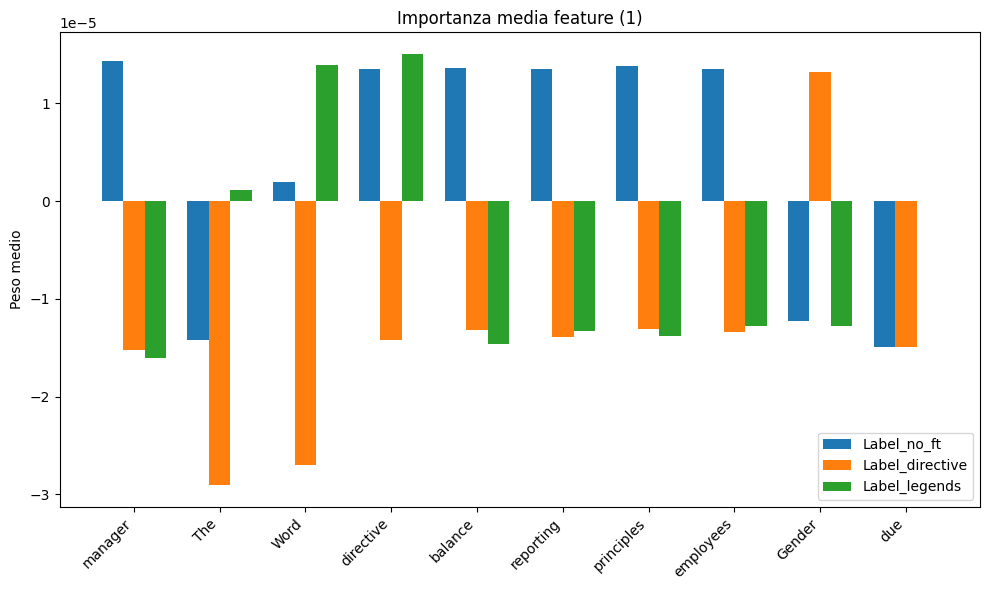

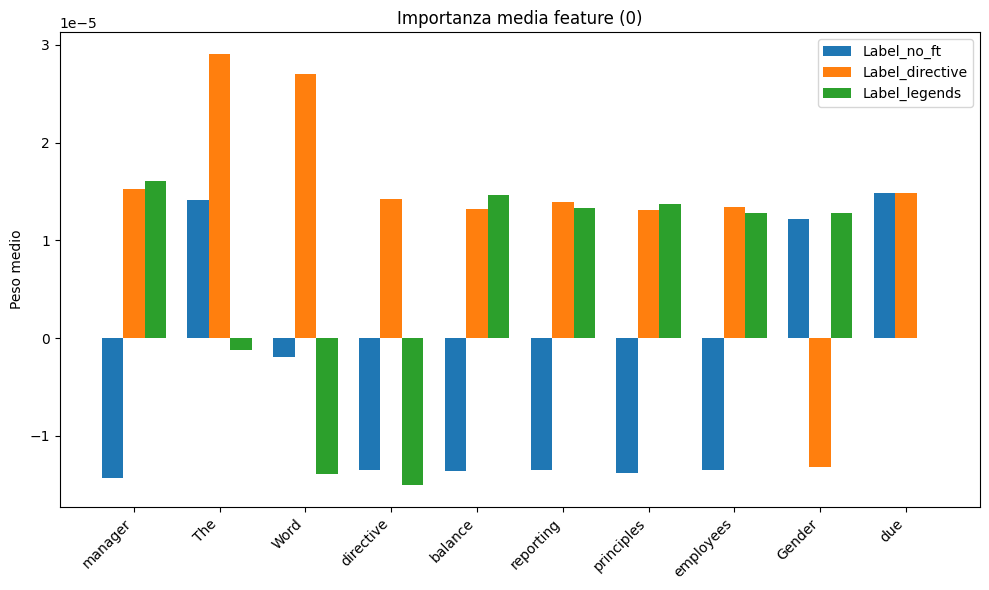

In [50]:
explain_LIME_aggregated(df_wic_error, ["Label_no_ft", "Label_directive", "Label_legends"], "WiC", 10)